# Prospecção de Dados 2022/2023
## Mestrado em Ciência de Dados | Second Home Assignment

### Group 14: Tiago Gil, No 59453 | Nuno Lopes, No 59461 | Daniela Moutinho, No 57064

In [88]:
from pyfim import pyeclat
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import  TransactionEncoder
from PD_freqitems import freqitemsets
import pandas as pd
import csv
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Load data from pickle file
orders = pickle.load(open("order_products.pickle", "rb"))

# Convert data to list of lists
order=[val for key, val in orders.items()]

In [ ]:
# Write data to a dat file (unecessary when using pyeclat directly in jupyter)
path = 'transaction_list.dat'
with open(path, 'w', newline='') as f:
    wr = csv.writer(f)
    wr.writerows(order)

with open('transaction_list.dat', 'r') as f:
    orders_eclat = [list(map(int, row)) for row in csv.reader(f)]

In [91]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname

In [93]:
print(products[28204])

Organic Fuji Apple


### Objective 1

In [36]:
tr_enc = TransactionEncoder()
trans_array = tr_enc.fit(order).transform(order, sparse=True)
binary_db=pd.DataFrame.sparse.from_spmatrix(trans_array,columns=[str(i) for i in tr_enc.columns_])

In [39]:
%timeit FI_apriori= apriori(binary_db, 0.10)
%timeit FI_fpg= fpgrowth(binary_db, 0.10)
%timeit FI_eclat= pyeclat(orders_eclat, 0.10)

636 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.28 s ± 62.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.2 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
D={"threshold": [0.2, 0.1, 0.05, 0.02, 0.015, 0.01], 
   "num_itemsets":[],
   "apriori":[], 
   "FP-growth":[], 
   "ECLAT":[], 
   "PD":[]}

for min_supp in D["threshold"]:
    t0 = time.time()
    FI_apriori=apriori(binary_db, min_supp)
    t1 = time.time()
    D["num_itemsets"].append(FI_apriori.shape[0])
    D["apriori"].append(t1-t0)

    FI_fpg= fpgrowth(binary_db, min_supp)
    t2 = time.time()
    D["FP-growth"].append(t2-t1)

    FI_eclat= pyeclat(orders_eclat, min_supp)    
    t3 = time.time()
    D["ECLAT"].append(t3-t2)

    FI_pdfis= freqitemsets(orders_eclat, min_supp)    
    t4 = time.time()
    D["PD"].append(t4-t3)

    
    print(min_supp, FI_apriori.shape[0],"\n\tApriori time:", t1-t0, 
          "\n\tFP-growth time:",t2-t1,
          "\n\tECLAT time:", t3-t2,
          "\n\tPD time:", t4-t3)
    
df_performance=pd.DataFrame(D)
df_performance

0.2 0 
	Apriori time: 0.661921501159668 
	FP-growth time: 4.924543142318726 
	ECLAT time: 23.384131908416748 
	PD time: 14.689454317092896
0.1 2 
	Apriori time: 0.6622276306152344 
	FP-growth time: 5.455636739730835 
	ECLAT time: 23.411083698272705 
	PD time: 14.876533508300781
0.05 6 
	Apriori time: 0.782524824142456 
	FP-growth time: 5.686054229736328 
	ECLAT time: 24.163416147232056 
	PD time: 15.019968032836914
0.02 39 
	Apriori time: 8.485401391983032 
	FP-growth time: 8.418365955352783 
	ECLAT time: 26.439044713974 
	PD time: 17.778353452682495
0.015 69 
	Apriori time: 24.90260934829712 
	FP-growth time: 15.669177532196045 
	ECLAT time: 27.688853979110718 
	PD time: 22.031962871551514
0.01 116 
	Apriori time: 285.744966506958 
	FP-growth time: 37.711196184158325 
	ECLAT time: 33.6409637928009 
	PD time: 31.739607095718384


,threshold,num_itemsets,apriori,FP-growth,ECLAT,PD
0,0.200,0,0.661922,4.924543,23.384132,14.689454
1,0.100,2,0.662228,5.455637,23.411084,14.876534
2,0.050,6,0.782525,5.686054,24.163416,15.019968
3,0.020,39,8.485401,8.418366,26.439045,17.778353
4,0.015,69,24.902609,15.669178,27.688854,22.031963
5,0.010,116,285.744967,37.711196,33.640964,31.739607


When first taking a look into this we first need to understand that all of the different algorithms will provide us with the same itemsets as each other as long as they are running they same minimum support level.

So when analyzing this point there would be a few things to take into consideration going from time complexity, itemsets generated and computacional requirements. Being that the itemsets generated will be equal between the 4 algorithms the main point that we are evaluating here is time complexity.

What we can observe is that there is an exponential growth in time complexity for Apriori and also a substancial growth in FP-Growth. While those two seem to have big increases in their own league we can observe that Eclat remains somewhat stable as the complexity of the issue increases (the minimum support level becomes lower) and the PD algorithm also shows potential on the same. But when observing these two side by side in each iteration there is a higher change that the Eclat will outperform PD if we were to lower the min support level just a little more.

With that said we did make a decision to run with the Eclat algorithm at a minimum support level of 0.01.

C:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tiago\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


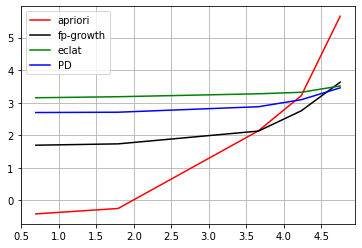

In [89]:
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["apriori"]),   c="r", label="apriori")
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["FP-growth"]), c="k", label="fp-growth")
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["ECLAT"]),     c="g", label="eclat")
plt.plot(np.log(df_performance["num_itemsets"]), np.log(df_performance["PD"]),        c="b", label="PD")
plt.grid()
plt.legend()
plt.show()

### Objective 2

In [49]:
FI_eclat= pyeclat(orders_eclat, 0.01)

In [69]:
rules = association_rules(FI_eclat, metric="confidence", min_threshold=0.1)

In [94]:
#This will serve to update the antecedents and consequentes from productID to productName (GPT Generated Method)
def map_product_names(itemset):
    return [products[item_id] for item_id in itemset]

In [95]:
rules["antecedents"] = rules["antecedents"].apply(map_product_names)
rules["consequents"] = rules["consequents"].apply(map_product_names)

In [103]:
rules_sort = rules.sort_values(["confidence", "lift"], ascending=False)
print(rules_sort.head(10))

               antecedents               consequents  antecedent support  \
0     [Organic Fuji Apple]                  [Banana]            0.027880   
8        [Organic Avocado]                  [Banana]            0.054999   
4    [Organic Raspberries]  [Bag of Organic Bananas]            0.042632   
14  [Organic Hass Avocado]  [Bag of Organic Bananas]            0.066436   
5           [Strawberries]                  [Banana]            0.044466   
6            [Large Lemon]                  [Banana]            0.047485   
2    [Organic Raspberries]    [Organic Strawberries]            0.042632   
24  [Organic Strawberries]  [Bag of Organic Bananas]            0.082331   
20  [Organic Baby Spinach]                  [Banana]            0.075251   
21  [Organic Strawberries]                  [Banana]            0.082331   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.146993  0.010558    0.378693  2.576259  0.006460    1.372923   
8  

Confidence measures the conditional probability of the consequent given the antecedent. Lift measures how much more likely the consequent is given the antecedent than if they were independent. With this in mind a way to examine for the most relevant rules of the dataset is to sort and check for the highest values of lift and confidence. While support and conviction measures also exist these present themselves as being more of a relationship strength check.

Example: [Organic Fuji Apple] -> [Banana] there is a lift of 2.576 and a confidence of 0.379. This could mean that people who get Organic Fuji Apple are 2.576 times more likely to get a Banana.

With the data transformed to use product names instead of product IDs we can find a very specific trend in our results of rules and these are that as people by various types of fruits there is a big trend that they will always also take bananas. There also seems to be a trend that if you are take any type of Organic food you are also more likely that your bag will include more items within that genre.

This values could also be influenced by quantity. Has some present a set of "Bag of Bananas" and some as "Bananas" but these in the dataset itself could prove to have an influence.

In [64]:
maximal_eclat= pyeclat(orders_eclat, 0.01, target="m")
print("Number of Maximal Itemsets", len(maximal_eclat))

Number of Maximal Itemsets 106


In [83]:
rules_maximal = association_rules(maximal_eclat, metric="confidence", min_threshold=0.005, support_only=True)

The only way we have to generate association rules for maximal itemsets is to specify the use of support_only. This is because association rules are generated by looking at the subsets of frequent itemsets and computing the confidence of the rules based on the support of the itemsets but because maximal itemsets do not have subsets there are no subsets to consider when generating association rules. In other words Maximal itemsets are "This means that maximal itemsets do not have any more frequent supersets, which is a requirement for computing association rules." (text in quotes GPT generated.)

In [52]:
closed_eclat= pyeclat(orders_eclat, 0.01, target="c")
print("Number of Closed Itemsets", len(closed_eclat))

Number of Closed Itemsets 116


In [97]:
rules_closed = association_rules(closed_eclat, metric="confidence", min_threshold=0.1)

In [98]:
rules_closed["antecedents"] = rules_closed["antecedents"].apply(map_product_names)
rules_closed["consequents"] = rules_closed["consequents"].apply(map_product_names)

In [102]:
rules_closed_sort = rules_closed.sort_values(["confidence", "lift"], ascending=False)
print(rules_closed_sort.head(10))

               antecedents               consequents  antecedent support  \
0     [Organic Fuji Apple]                  [Banana]            0.027880   
8        [Organic Avocado]                  [Banana]            0.054999   
4    [Organic Raspberries]  [Bag of Organic Bananas]            0.042632   
14  [Organic Hass Avocado]  [Bag of Organic Bananas]            0.066436   
5           [Strawberries]                  [Banana]            0.044466   
6            [Large Lemon]                  [Banana]            0.047485   
2    [Organic Raspberries]    [Organic Strawberries]            0.042632   
24  [Organic Strawberries]  [Bag of Organic Bananas]            0.082331   
20  [Organic Baby Spinach]                  [Banana]            0.075251   
21  [Organic Strawberries]                  [Banana]            0.082331   

    consequent support   support  confidence      lift  leverage  conviction  \
0             0.146993  0.010558    0.378693  2.576259  0.006460    1.372923   
8  

Generating association rules from a closed frequent itemset is supposed to be more eficient than generating all rules as it eliminates redundancy that could come up from multiple frequent itemsets that have the same items. However in this specific case when generating the frequent itemsets using eclat with a target on closed items we were presented with the fact that the itemsets were the same as the default eclat.

While this can happen it is also very dataset-specific as using closed algorithms in different datasets will in fact generate different results for itemsets.

This leading to the same conclusions we had on our default eclat analysis.